<h1> PyKrev User Guide </h1> 

**Hello.** Welcome to the PyKrev user guide. In this document we will explore how to set up and use PyKrev in the analysis of FT-MS data. <br> <br>
**What is Pykrev?** PyKrev is a python package containing functions that allow visualisation and statistical analysis of FT-MS data in python. PyKrev is intended to be used in the final part of mass spectrometry data analysis, after the spectra have been calibrated and peaks have been assigned to molecular formula. <br> <br>
**What data do I need to use PyKrev?** PyKrev was designed to analyse low weight molecular formula uncovered from high resolution mass spectra. The core data sets needed to use PyKrev are lists of molecular formula strings and corresponding numpy arrays of peak intensities and mz values. PyKrev can parse an output .csv file from PNNL's formularity software to generate these datasets for you. <br> <br>
**How do I install PyKrev?**  PyKrev can be installed directly from the Python Packaging Index. Run the command ``` pip install pykrev ``` from your terminal.<br> <br>
**What are the PyKrev dependencies?** PyKrev is written in Python 3. To use PyKrev you must have the matplotlib (version >= 3.3.3), numpy (>= 1.19.3) and pandas (>= 1.1.5) libraries installed. For additional functionality such as gaussian density estimation and multivariate analysis, you will also need to install SciPy (>=1.5.4). <br> <br>
**Can I try out PyKrev without installing Python?**  Yes, this is possible using mybinder.org, which is a virtual notebook environment containing all the Python libraries needed to use PyKrev. Click the button below to launch a binder environment, then navigate to this user guide which is located at 'docs/user_guide/PyKrevUserGuide.ipynb'. You can try out the other guides too. *Note: KEGG database compound matching does not work in the Binder version of PyKrev.* <br>
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Kzra/pykrev/HEAD)


**Overview of PyKrev Module Organisation:**
![PyKrev Module Organisation](pykrev_module_organisation.png "Module Organisation")

**How to use this guide**: 
* Descriptions of functions will be given as bullet points. **```function_names```** are given in bold. 
* Python code demonstrating the functions will then be shown in the code cell(s) directly below.
* The guide is split up into three sections. 
 * Part 1: Formula: reading in data and basic formula manipulation. 
 * Part 2: Plotting: plotting van krevelen diagrams, histograms and other visualisations. 
 * Part 3: Diversity and multivariate analysis: performing statistical analysis on data and calculating chemical diversity.
* If you open this guide as a .ipynb file using Jupyter Notebook or Jupyter Lab you can run the code cells directly using the Python interpreter.
* To begin with we will import the packages we need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pykrev as pk

<h3> Part 1: Basic formula manipulation </h3>

1.1: PyKrev uses two data types. An ```msTuple``` is used to analyse a single spectrum, and an ```msTupleDict``` is used to analyse multiple spectra. <br>
   * An ```msTuple``` is a [tuple](https://www.w3schools.com/python/python_tuples.asp) containing three objects in the following order:
      * (1) An list of molecular formula strings. 
         * Molecular formula strings should be written in the form $C_{C}H_{H}N_{N}O_{O}P_{P}S_{S}$.  
         * $C_{6}H_{12}O_{6}$ would be written 'C6H12O6'.
         * PyKrev cannot parse isotopologue formula strings (e.g. C9H12O6 13C1).
         * Currently PyKrev only supports formula with C,H,N,O,P and S assignments.
      * (2) An numpy.ndarray of corresponding peak intensities
      * (3) An numpy.ndarray of corresponding calibrated m/z values <br><br>
   * An ```msTupleDict``` is a [dictionary](https://www.w3schools.com/python/python_dictionaries.asp) containing sample names as keys and ```msTuples``` as values.<br><br>
   * You can import your data into an msTuple however you like. PyKrev contains functions designed to parse specific file formats.
      * If you want to analyse formula assigned using [formularity software](https://omics.pnl.gov/software/formularity), you can use **```read_formularity```**. This function automatically filters out mass charge values that don't have C and H atoms assigned to them and formula with 13C assignments. **```read_batch_formularity```** can be used to load in a batch formularity file where multiple spectra have been assigned using the same alignment.
      * PyKrev can also read the output of the CoreMS Python library using **```read_corems```** this function also filters isotopologue assignments. This allows you to do all of your MS data processing, from raw data file to statistical and graphical analysis of formula assignments, in Python. [Click here for a guide on using CoreMS with PyKrev.](https://nbviewer.jupyter.org/github/Kzra/pykrev/blob/master/docs/corems_with_pykrev/CoreMsWithPykrev.ipynb)

In [2]:
#METHOD 1: READ IN A SINGLE SPECTRUM FORMULARITY FILE
#read a formularity file, and extract formula, peak intensities, mass charge ratios, and compound classes. 
A = pk.read_formularity('../example_data/formularity_example_A.csv',pi_col = 'peak_intensity') #pi_col provides the column name for peak intensities.
B  = pk.read_formularity('../example_data/formularity_example_B.csv',pi_col = 'peak_intensity')
C = pk.read_formularity('../example_data/formularity_example_C.csv',pi_col = 'peak_intensity')

#A is an msTuple
print(type(A))
#A.formula is a list
print(type(A.formula))
#A intensity, and A.mz are numpy.ndarrays
print(type(A.intensity))
print()
#We can summarise the objects in A 
A.summary()

<class 'pykrev.formula.msTuple.msTuple'>
<class 'list'>
<class 'numpy.ndarray'>

assigned formula = 3333 
min intensity = 826769.0
max intensity = 6180546560.0
mean mz = 534.5778631953195 
std mz = 194.91027234489434 


In [3]:
#METHOD 2: READ IN A BATCH SPECTRA FORMULARITY FILE
#read in a batch alignment formularity file using read_batch_formularity
msTupleDict = pk.read_batch_formularity('../example_data/batch_formularity.csv')
#This produces am msTupleDict in which sample names are keys and corresponding msTuples are values
D = msTupleDict['SAMPLE D']
D.summary()

assigned formula = 761 
min intensity = 2395944
max intensity = 1455153536
mean mz = 331.44510284638636 
std mz = 92.83327930631756 


In [4]:
#METHOD 3: LOAD IN YOUR DATA MANUALLY
brite_df = pd.read_csv('../example_data/Brite_DF.csv',index_col = 0) #Load the BRITE Biological molecules excel file
brite_formula = brite_df['F'][brite_df['F'].notnull()].to_list() #extract the formula
brite_intensities = np.random.rand(len(brite_formula)) 
brite_mass_charge = pk.calculate_mass(brite_formula)
BRITE = pk.msTuple(brite_formula, brite_intensities, brite_mass_charge) #Manually create an msTuple from separate objects 
BRITE.summary()

assigned formula = 590 
min intensity = 0.005555046961706944
max intensity = 0.9994345717824329
mean mz = 344.8713852280633 
std mz = 318.90203613565444 


1.2: An ```msTuple``` can be filtered by mz, intensity and  can also be filtered for spectral interferences caused by [high molecular weight doubly charged molecular ions](https://doi.org/10.1021/jasms.0c00353).

In [5]:
#A = A.filter_mz(400,500) #Note, filtering is not in place (an msTuple is immutable)
#A = A.filter_intensity(1e6,1e7)
A = A.filter_spectral_interference(tol=2)

75 interferences removed.


1.3: Most functions in PyKrev take an msTuple as input. Below we calculate C, H, N, O, P & S counts in each formula, as well as element ratios using **```element_counts```** and **```element_ratios```**.

In [6]:
elementCounts = pk.element_counts(A)
elementRatios = pk.element_ratios(A, ratios = ['HC','OH','OC'])
print(f'formula = {A.formula[0]}') #The first formula in the msTuple
print(f'element counts = {elementCounts[0]}') #the result is a list of len(A.formula) in which each item is a dictionary containing C,H,N,O,P,S counts
print(f'element ratios = {elementRatios[0]}') #the result is a list of len(A.formula) in which each item is a dictionary containing the ratios given in ratios 

formula = C6H6O2
element counts = {'C': 6, 'H': 6, 'N': 0, 'O': 2, 'P': 0, 'S': 0}
element ratios = {'HC': 1.0, 'OH': 0.3333333333333333, 'OC': 0.3333333333333333}


1.4: It is also possible to calculate double bound equivalent, aromaticity index, and [nominal oxidation state of carbon](https://www.sciencedirect.com/science/article/abs/pii/S0016703711000378?via%3Dihub) using **```double_bond_equivalent```**, **```aromaticity_index```** and **```nominal_oxidation_state```**.

In [7]:
dbe = pk.double_bond_equivalent(A) # the result is a numpy.ndarray of len(A.formula)
ai = pk.aromaticity_index(A, index_type = 'rAI') # index_type can be reformulated or original, and account for a modified O coefficient.
nosc = pk.nominal_oxidation_state(A)
print(f'dbe = {dbe[0]}') 
print(f'ai = {ai[0]}') 
print(f'nosc = {nosc[0]}')

dbe = 4.0
ai = 0.3333333333333333
nosc = -0.33333333333333304


1.5: PyKrev can be used to calculate average, exact monoisotopic and nominal monoisotopic masses from an msTuple using **```calculate_mass```**. 
  * **```calculate_mass```** allows you to calculate mass for close shell ions (M+H)+ or (M-H)- or radicals (M.-). This can be used to calculate the relative mass error of your calibrated mass values in ppm. 

In [8]:
nominalMass = pk.calculate_mass(A, method = 'nominal') 
averageMass = pk.calculate_mass(A, method = 'average') 
monoisotopicMass = pk.calculate_mass(A, method = 'monoisotopic') 
massExpected = pk.calculate_mass(A, method = 'monoisotopic', ion_charge = -1, protonated = True) #Calculates the expected mass of a deprotonated analyte e.g. [M-H]-, negative mode ESI ionisation
massError = (massExpected - A.mz)/A.mz * 1e6 # You can then calculate the relative mass error in ppm using the following equation

print(f'nominal mass = {nominalMass[0]}')
print(f'average mass = {averageMass[0]}')
print(f'monoisotopic mass = {monoisotopicMass[0]}')
print(f'expected mass =  {massExpected[0]}')
print(f'calibrated mass = {A.mz[0]}')
print(f'mass error (ppm) = {massError[0]}')

nominal mass = 110.0
average mass = 110.110872
monoisotopic mass = 110.0367794325774
expected mass =  109.0295029003384
calibrated mass = 109.02949
mass error (ppm) = 0.11831971702903514


1.6: You can calculate the kendrick mass and kendrick mass defect on an array of calibrated mz values using **```kendrick_mass_defect```**. 

In [9]:
# Kendrick mass and kendrick mass defect
kendrickMass, kendrickMassDefect = pk.kendrick_mass_defect(A, base = ['CH2'], rounding = 'even')  #even rounding behaviour for kmd calculation, can also be floor, ceil, or rint
print(f'kendrick mass = {kendrickMass[0]}')
print(f'kendrick mass defect = {kendrickMassDefect[0]}')

kendrick mass = 108.90774619641944
kendrick mass defect = 0.09225380358056157


1.7: You can call ```help``` on any function to read the documentation.

In [10]:
help(pk.aromaticity_index)

Help on function aromaticity_index in module pykrev.formula.aromaticity_index:

aromaticity_index(msTuple, index_type='rAI')
    Docstring for function pykrev.aromaticity_index
    This function takes an msTuple and returns the aromaticity index of each formula in the formula list.
    
    Use
    ----------
    aromaticity_index(Y)
    
    Returns a numpy.ndarray of len(Y[0]) in which each item, i ,is the aromaticity index corresponding to Y[0][i].  
    
    Parameters
    ----------
    Y: msTuple OR a list of molecular formula strings
    
    index_type: String, one of:
        -'rAI' - reformulated aromaticity index see Mendelez-Perez et al. (2016)
        -'rAImod'- reformulated aromaticity index with modified oxygen coefficient 
        -'AI' - aromaticity index see Koch and Dittmar (2006) 
        -'AImod'- aromaticity index with modified oxygen coefficient see Koch and Dittmar (2006)
    
    
    Info
    ----------
    Reformulated aromaticity index see Mendelez-Perez et 

<h3> Part 2: Plotting </h3>

2.1: PyKrev can be used to make a range of van Krevelen style plots from your data. Plotting in PyKrev is performed using the [API interface of matplotlib](https://matplotlib.org/tutorials/introductory/pyplot.html), this means that you can continue to customise your plots once they have been produced using a range [matplotlib.pyplot commands](https://matplotlib.org/api/pyplot_summary.html). <br> 
 * Plotting functions in PyKrev also return the figure and axes handles of the plot, so you can use the [object oriented interface of matplotlib](https://medium.com/@kapil.mathur1987/matplotlib-an-introduction-to-its-object-oriented-interface-a318b1530aed) to make additional alterations if you would like. This is not necessary to make professional looking figures so don't worry about these handles if you aren't sure on how to use them.   <br> <br>  
 * A standard van krevelen plot is made using **```van_krevelen_plot```** on an msTuple. The function can take keyword arguments for [pyplot.scatter.](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html#matplotlib.pyplot.scatter)
    * You can apply patches to the plot denoting compound class boundaries (taken from those used by PNNL's formularity software) by passing the boundaries of interest in a list to ```patch_classes```.

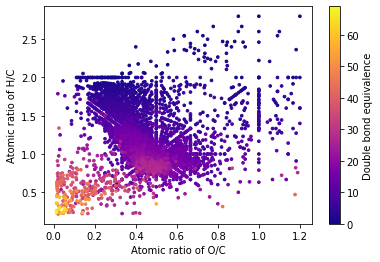

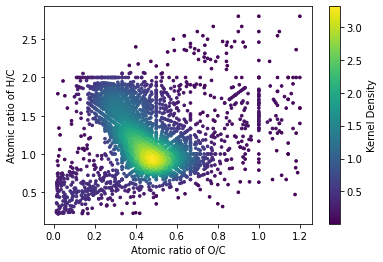

In [11]:
#Here we make a van Krevelen style plot where the y axis represents N/C values, and colour code the points by double bond equivalence 
plt.figure()
pk.van_krevelen_plot(A, y_ratio = 'HC',c = dbe,s = 7,cmap = 'plasma') #van_krevele_plot takes any keyword arguments that can be passed to pyplot.scatter() 
cbar = plt.colorbar() #add a colour bar 
cbar.set_label('Double bond equivalence')
plt.grid(False)
#PyKrev.van_krevelen_plot can take the value 'density' for the key word argument 'c' to colour code points based on kernel density
plt.figure()
pk.van_krevelen_plot(A ,c='density',s = 7)
plt.colorbar().set_label('Kernel Density')
plt.grid(False)

2.2: We can also make 2d histograms based on a list of molecular formula using **```van_krevelen_histogram```**. The function can take keyword arguments passed to [pyplot.hist2d](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist2d.html). If the bin sizes are given as scalar values, a 'density index' is returned. This is a value between 0 and 1 made by dividing the average number of points by the number of points in the most populated bin, giving average relative density (for 100 bins a score of 1 means all bins are equally dispersed, and a score of 0.01 means all points fall into one bin).

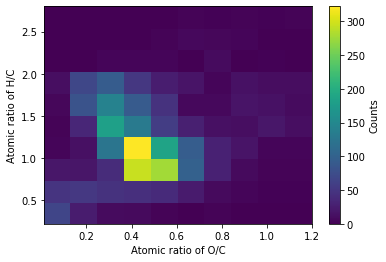

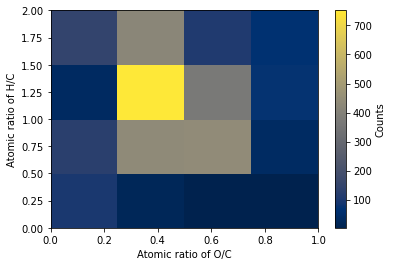

In [12]:
plt.figure()
fig, ax, d_index = pk.van_krevelen_histogram(A,bins = [10,10],cmap = 'viridis') # van_krevelen_histogram takes any key word argument that can be passed to pyplot.hist2d
cbar = plt.colorbar()
cbar.set_label('Counts')
#a histogram can also be made with a range of values for bins
plt.figure()
fig, ax, d_index = pk.van_krevelen_histogram(A,bins = [np.linspace(0,1,5),np.linspace(0,2,5)],cmap = 'cividis') # van_krevelen_histogram takes any key word argument that can be passed to pyplot.hist2d
cbar = plt.colorbar()
cbar.set_label('Counts')

2.3: [**Kendrick mass defect plots**](https://doi.org/10.1021/acs.analchem.9b03333) are a useful way to identify chemically related compounds based on exact measurements. With pykrev you can make them using **```kendrick_mass_defect_plot```**.

(250.0, 1000.0)

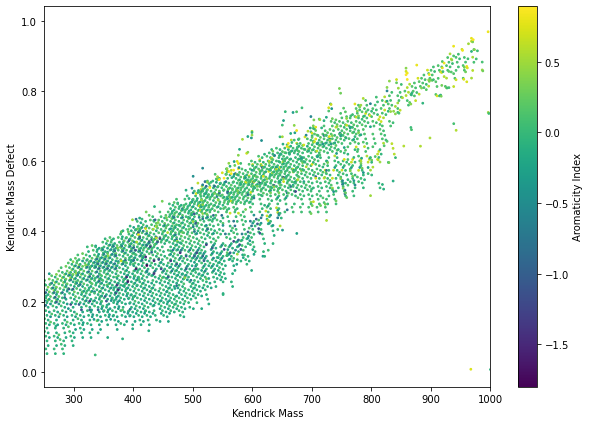

In [13]:
plt.figure(figsize = (10,7))
fig, ax ,(kendrickMass, kendrickMassDefect) = pk.kendrick_mass_defect_plot(A, base = 'CH2', rounding = 'ceil', s = 3, c = ai)
plt.colorbar().set_label('Aromaticity Index')
plt.xlim([250,1000])

2.4: **Atomic Class Plots** enable you to see the distribution of an element within your sample, and the summary statistics show the mean, median and standard deviation of that distribution. Make them using **```atomic_class_plot```**.

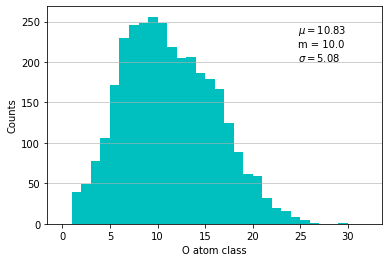

In [14]:
plt.figure()
fig, ax, (mean,median,sigma) = pk.atomic_class_plot(A, element = 'O', color = 'c', summary_statistics = True, bins = range(0,33))

2.5: **Compound class plots** are useful to see the breakdown of compound classes in a sample. Make them using **```compound_class_plot```**. There is more about the **```compound_class```** function in the next section.

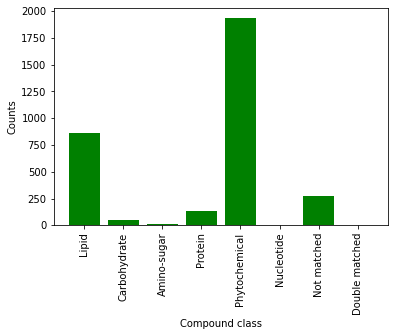

In [15]:
plt.figure()
fig, ax, (compounds, counts) = pk.compound_class_plot(A, color = 'g', method = 'MSCC')

2.6: **Mass histograms** show the distribution of mass in your sample. You can specify the bin width in mass units, and the method used to calculate mass. You can visualise the data as histogram bars or using gaussian kernel density estimation (in which case the Y value will be a probability density function). Make them using **```mass_histogram```**.

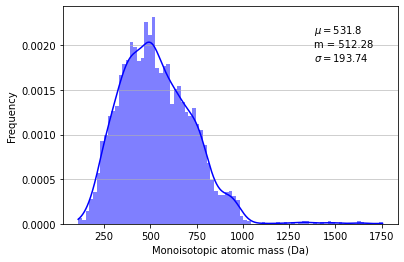

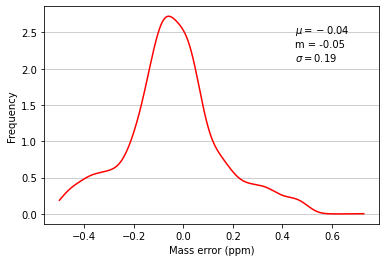

In [16]:
plt.figure()
fig, ax, (mean,median,sigma) = pk.mass_histogram(A, method = 'monoisotopic', bin_width = 20, summary_statistics=True, 
                                                 color = 'blue', alpha = 0.5, kde = True, kde_color = 'blue', density = False)
plt.xlabel('Monoisotopic atomic mass (Da)')

plt.figure()
fig,ax, (mean,median,sigma) = pk.mass_histogram(A, method = 'me', kde = True, hist = False, kde_color = 'red', summary_statistics=True, deprotonated = True, ion_charge = -1)

2.7: **```Mass_spectrum```** recreates a mass spectrum based on an assiged formula list. You can specify the method used to calculate mass, and whether or not to sum normalise the peak intensity list (divide by sum, so all intensities is sample sum to 1).

(150.0, 1000.0)

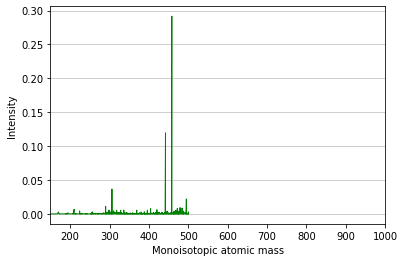

In [17]:
plt.figure()
fig, ax = pk.mass_spectrum(A.filter_mz(0,500), method = 'monoisotopic',normalise = True, color = 'g',linewidth = 1)
plt.xlim(150,1000)

2.8: Matplotlib offers a range of customisation options to change the appearance of plots. Be sure to play around with key word arguments to get the plots just how you like them. In addition it's possible to [change the appearance of the text](https://matplotlib.org/tutorials/introductory/customizing.html) and [the overall style of the plot.](https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html).

<h3> Part 3: Chemical diversity and multivariate analysis </h3>

* 3.1: PyKrev can be used to predict the compound class make up of a sample, it can also be used to compute diversity values (akin to biological diversity metrics) based on the peak intensities of molecular formula present in a sample. Finally, it can also be used to concatenate multiple formula and peak intensity lists into a sample data matrix which can then be used to perform statistical ordination such as PCA and PCoA. 

    * To estimate the compound class composition of a sample, use the **```compound_class```** function. A variety of criteria can be used to predict compound class, which are discussed in the function's docstring. Below we compare the [MSCC algorithm](https://pubs.acs.org/doi/full/10.1021/acs.analchem.8b00529), the [KELL method](https://doi.org/10.1038/ncomms4804) and the KEGG_All method (which matches compounds to entries in the [KEGG Compound Database](https://www.genome.jp/kegg/compound/)).

In [18]:
compounds, counts = pk.compound_class(A, method = 'MSCC') #The function returns a list of compounds of len (formula_list) and a dictionary containing the totals 
print(counts)
print('\n')
compounds, counts = pk.compound_class(A, method = 'KELL') #The function returns a list of compounds of len (formula_list) and a dictionary containing the totals 
print(counts)
print('\n')
compounds, counts = pk.compound_class(A, method = 'KEGG_All') #The function returns a list of compounds of len (formula_list) and a dictionary containing the totals 
print(counts)

{'Lipid': 857, 'Carbohydrate': 51, 'Amino-sugar': 10, 'Protein': 132, 'Phytochemical': 1933, 'Nucleotide': 0, 'Not matched': 275, 'Double matched': 0}


{'Combustion-derived polycyclic aromatics': 92, 'Vascular plant-derived polyphenols': 80, 'Highly unsaturated and phenolic compounds': 2254, 'Aliphatic compounds': 832}


{'Not Matched': 3094, 'Polyketides': 28, 'Flavonoids': 0, 'Organic acids': 5, 'Carbohydrates': 8, 'Phenylpropanoids': 11, 'Shikimate / acetate-malonate pathway derived compounds': 1, 'Peptides': 0, 'PR  Prenol lipids': 0, 'Cyanotoxins': 0, 'Amino acid related compounds': 1, 'SP  Sphingolipids': 0, 'Fatty acids related compounds': 1, 'Phytotoxins': 5, 'ST  Sterol lipids': 7, 'GP  Glycerophospholipids': 0, 'Antibiotics': 1, 'Fungal toxins': 9, 'Nucleic acids': 0, 'Others': 1, 'FA  Fatty acyls': 12, 'Hormones and transmitters': 0, 'Vitamins and Cofactors': 1, 'GL  Glycerolipids': 0, 'Venoms': 0, 'Steroids': 11, 'Lipids': 14, 'Terpenoids': 47, 'Marine biotoxins': 0, 'SL  

* 3.2: To compute diversity metrics we can use **```diversity_indices```**. **```Diversity_indices```** requires a list of molecular formula, and a corresponding list of peak intensities. Based on these datasets the function calculates molecular richness, abundance-based ([Shannon-wiener](https://en.wikipedia.org/wiki/Diversity_index#Shannon_index) and [Gini-simpson](https://en.wikipedia.org/wiki/Diversity_index#Gini%E2%80%93Simpson_index) and functional-based ([using rao's quadratic entropy](https://www.sciencedirect.com/science/article/pii/S0040580909001117)) diversity values for the sample. [Tanentzap et al. (2019)](https://www.pnas.org/content/116/49/24689) shows how these measurements can be applied in chemical analysis.

In [19]:
A_diversity = pk.diversity_indices(A, verbose = True, indices = ['SW','DBE']) #diversity values are saved into a dictionary 
A_diversity['D_a_SW'] #shannon wiener diversity
A_diversity['D_f_DBE']#functional diversity based on double bond equivalence 

Abundanced based diversity:
Shannon-Wiener Index: 5.879296767522895 

Functional based diversity:
Raos Quadratic Index (DBE):  3.7187044066312684


3.7187044066312684

In [20]:
help(pk.diversity_indices)

Help on function diversity_indices in module pykrev.diversity.diversity_indices:

diversity_indices(msTuple, indices=['r', 'GS', 'SW', 'C', 'O', 'NOSC', 'DBE', 'rAI', 'HC', 'OC'], verbose=True)
        Docstring for function pyKrev.diversity_indices
        This function takes an msTuple and calculates a variety of diversity estimates (richness, abundance-based and functional.)
    
        Use
        ----
        diversity_indices(Y)
    
        Returns a dictionary containing the values listed in 'indices'.   
    
        Parameters
        ----------
        Y: msTuple
        indices: a list of strings specifying the specific diversity indices to calculate, can include:
        'r' : molecular richness (i.e. number of molecular formula)
        'GS': Gini-simpson abundance based alpha diversity (species eveness)
        'SW': Shannon Wiener abundance based alpha diversity
        'C' : C number functional diversity
        'O' : O number functional diversity
        'N' : N numb

* 3.3: In order to cross compare molecular formula datasets in multivariate analysis it is first required to construct a sample data matrix in which each column represents a molecular formula each row a different sample. The len(rows) is equal to len(samples) and the len(columns) is equal to the len(set(all_formula)), where all_formula is all formula found across the samples. \[row,col\] value is the peak intensity of a particular molecular formula in a particular sample. If the formula is not present in a sample the peak intensity is set as impute value. We can construct this sample data matrix using **```ordination_matrix```**.

In [21]:
msTupleDict = pk.msTupleDict()
msTupleDict['A'] = A
msTupleDict['B'] = B
msTupleDict['C'] = C
sample_data_matrix = pk.ordination_matrix(msTupleDict,
                                          impute_value = 0) #you can define a custom impute value, if 'nan' sets value as np.nan
sample_data_matrix.iloc[:,1:10]

,C14H24O6,C22H24O9,C37H32O19,C18H14O12,C33H40O10,C23H26N6O16,C42H44O16,C29H52O7,C45H58N4O9
A,3.72468e+06,7.83028e+06,1.56995e+07,1.51033e+06,2.51454e+06,1.97272e+06,1.92803e+06,0,0
B,4.07962e+06,0,1.32772e+07,0,0,0,0,0,0
C,2.74309e+07,1.10849e+07,6.92399e+06,3.92217e+06,0,0,0,5.01321e+06,2.49484e+06


In [22]:
help(pk.ordination_matrix)

Help on function ordination_matrix in module pykrev.diversity.ordination_matrix:

ordination_matrix(msTupleDict, impute_value='nan')
        Docstring for function pyKrev.ordination_matrix
        This function computes a sample data matrix from an msTupleDict
    This matrix can be used for further ordination analysis (e.g. PCA, PCoA...)
    
        Use
        ----
        ordination_matrix(Y)
    
        Returns a pandas dataframe in which the column headers are a set of all formula found in msTupleDict and the rows correspond to a specific sample.
    The [row,col] value of the dataframe is therefore the peak intensity of a formula. Impute value (default 0) if the formula was not present. 
    
        Parameters
        ----------
        Y: an msTupleDict
    impute_value: the value to impute when a formula isn't present in a group. An integer or float or 'nan' (default 0):



* 3.5: We can normalise the peak intensities in the sample data matrix by using **```normalise_intensity```**. This is a powerful function that can perform several types of normalisation. It can also subset the data prior to generating normalisation factors, [as described here](https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/10.1002/rcm.9068). Below we perform a few types of normalisation.
   * Look at the function documentation for more information.

In [23]:
# Sum relative intensity
sum_norm_matrix = pk.normalise_intensity(sample_data_matrix, norm_method = 'sum', norm_subset = 'ALL', log = False) 
assert sum(sum_norm_matrix.iloc[0,:]) > .99 and sum(sum_norm_matrix.iloc[0,:]) < 1.01 #rows sum to 1 

#Unit vector relative intensity
unit_norm_matrix = pk.normalise_intensity(sample_data_matrix, norm_method = 'unit_vector', norm_subset = 'ALL', log = False) 
assert sum(unit_norm_matrix.iloc[0,:]**2) > .99 and sum(unit_norm_matrix.iloc[0,:]**2) < 1.01 #rows squared sum to 1 

#Z score relative intensity (aka snv)
zscore_norm_matrix = pk.normalise_intensity(sample_data_matrix, norm_method = 'zscore', norm_subset = 'ALL', log = False)
assert np.std(zscore_norm_matrix.iloc[0,:]) >.99 and np.std(zscore_norm_matrix.iloc[0,:]) < 1.01 # rows have standard deviation of 1 and mean of 0 

#In the following example, the data is first subsetted to only formula that are present in 50% of rows.
#The normalisation factors (in this case the standard deviation and mean) are then calculated on that subset. 
zscore_sub_norm_matrix = pk.normalise_intensity(sample_data_matrix, norm_method = 'zscore', norm_subset = 'PPP', p_P = 0.5, log = False)

#In the following example, the data is first subsetted to the top 100 formula (ranked by peak intensity) in each row.
#The normalisation factors (in this case the standard deviation and mean) are then calculated on that subset. 
#The input data is log transformed before subsetting or normalisation. . 
zscore_sub_norm_matrix = pk.normalise_intensity(sample_data_matrix, norm_method = 'zscore', norm_subset = 'LOS', p_L = 100, log = False)

#In the following example, a relative intensity calculation isn't performed. Instead a binary (presence/absence) matrix is constructed.
#If a formula is present in a sample, it is given the value 1.0, else it is given the value 0.0  
binary_norm_matrix = pk.normalise_intensity(sample_data_matrix, norm_method = 'binary', norm_subset = 'ALL', log = False)
(binary_norm_matrix.head().iloc[:,1:10])

 There are 2620 peaks/formula in your subset.


,C14H24O6,C22H24O9,C37H32O19,C18H14O12,C33H40O10,C23H26N6O16,C42H44O16,C29H52O7,C45H58N4O9
A,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
B,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
C,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0


In [24]:
help(pk.normalise_intensity)

Help on function normalise_intensity in module pykrev.diversity.normalise_intensity:

normalise_intensity(input_matrix, norm_method='sum', norm_subset='ALL', p_L=500, p_P=0.5, log=False)
        Docstring for function pykrev.normalise_intensity 
        This function takes an intensity data matrix and applies a normalisation method on the rows of the data.
        Normalisation consists of two processes: (1) applying a subset method to the data, (2) generating normalisation factors (e.g. mean, median, zscore)
        based on that subset which are then applied to the entire dataset.
    
        Use
        ----------
        normalise_intensity(Y)
    
        Returns a numpy array or pd.dataframe of shape(Y) in which each value corresponds to the row normalised intensity.  
    
        Parameters
        ----------
        Y: A numpy array of shape Y[samples,formula] containing peak intensities OR an ordination matrix produced by pk.ordination matrix 
        method: A string decrib

* 3.6: We could perform PCA (Principal component analysis) directly on the normalised intensity matrix, or compute a non-euclidean distance measure, such as [bray-curtis dissimilarity](https://en.wikipedia.org/wiki/Bray%E2%80%93Curtis_dissimilarity) to perform PCoA (Principal coordinate analysis).  This can be done using **```bray_curtis_matrix```**.

In [25]:
bray_curtis = pk.bray_curtis_matrix(np.array(sum_norm_matrix)) #note bray_curtis_matrix requires a numpy.array so won't work directly on sample_data_matrix

* 3.7: Our data is now ready for dimensionality reduction. [Click here for a guide on how to do PCA with PyKrev.](https://nbviewer.jupyter.org/github/Kzra/pykrev/blob/master/docs/pca_with_pykrev/PCAwithPyKrev.ipynb)

**That's the end of the user guide.** Thanks for reading, if you have any comments or feedback do let me know. I recommend reading the batch analysis tutorial notebook next. 
